In [237]:
import requests
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import architecture
from IPython.display import display
import torch.optim as optim
from architecture import LSTM
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import math
import matplotlib.animation as animation 
import logging
import itertools
from IPython.display import HTML
%matplotlib inline
torch.manual_seed(1)
pd.set_option("display.precision", 8)

In [220]:
# Load Data
SFX_BTC_df = pd.read_csv(f'data/SFX_BTC_minute.csv')
BTC_RSD_df = pd.read_csv(f'data/BTC_RSD_minute.csv')
ETH_BTC_df = pd.read_csv(f'data/ETH_BTC_minute.csv')
ETH_RSD_df = pd.read_csv(f'data/ETH_RSD_minute.csv')
SFT_RSD_df = pd.read_csv(f'data/SFT_RSD_minute.csv')
SFX_RSD_df = pd.read_csv(f'data/SFX_RSD_minute.csv')

empty_daterange = pd.date_range(start='2019-06-26 00:00', end='2020-05-25 00:00', freq='T')
df = pd.DataFrame(index=empty_daterange, columns=['A'])

df_list = [SFX_BTC_df, BTC_RSD_df, ETH_BTC_df, ETH_RSD_df, SFT_RSD_df, SFX_RSD_df]
df_list = sorted(df_list, key=len, reverse=True)
for i, df in enumerate(df_list):
    df_list[i].index = pd.to_datetime(df_list[i].timestamp)
    df_list[i].fillna(method='ffill', inplace=True)
    df_list[i] = df_list[i]['2019-06-26 00:00':'2020-05-25 00:00']
    _, df_list[i] = df.align(df_list[i], join='inner', axis=0, method='ffill')
    df_list[i]['quantity'].fillna(0, inplace=True)
    df_list[i].drop(['timestamp'], axis=1, inplace=True)
    df_list[i] = df_list[i].loc[~df_list[i].index.duplicated(keep='last')]        

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [221]:
len(empty_df)

478081

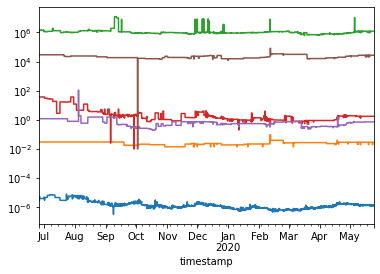

In [241]:
for df in df_list:
    df['close'].plot(logy=True)